In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit

In [3]:
import vice

from surp import subgiants
from surp import gce_math as gcem
from surp.gce_math import MH_to_Z, Z_to_MH, Z_SUN
import surp

import arya

/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [4]:
from scipy.stats import t, norm


In [5]:
arya.style.set_size((4, 2*np.sqrt(2)))

In [6]:
surp.set_yields()

In [8]:

filt = ~subgiants.high_alpha.values
df = subgiants[filt]

x_obs = df.MG_H.values
y_obs = df.C_MG.values
x_err = df.MG_H_ERR.values
y_err = df.C_MG_ERR.values
obs = (x_obs, y_obs, x_err, y_err)
w = 1/y_err**2 

In [11]:
all_abundances = pd.read_csv("data_analysis/all_data.csv")
stars = pd.read_csv("../data/amarsi_19.tsv", delimiter="\t *", comment="#", skiprows=[62, 63], engine="python")
stars["C_MG"] =  stars["[C/H]3N"] - stars["[O/H]3N"]
stars["MG_H"] =  stars["[O/H]3N"]
stars["C_MG_ERR"] = stars["e_[C/H]3N"] + stars["e_[O/H]3N"]

df_stars = stars[["C_MG", "MG_H", "C_MG_ERR"]]

all_abundances["C_MG"] = all_abundances["[c/o]"]
all_abundances["MG_H"] = all_abundances["[o/h]"]
all_abundances["C_MG_ERR"] = all_abundances["[c/o]_err"]

stars_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "star")]
RL_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "RL")]
DLA_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "DLA")]
dwarf_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "dwarf")]

In [12]:
stars_x_obs = stars.MG_H
stars_y_obs = stars.C_MG
all_x_obs = all_abundances.MG_H
all_y_obs = all_abundances.C_MG

# MCMC fits

In [13]:
import emcee
from corner import corner

In [14]:
class LinearModel():
    def __init__(self):
        pass
            
    def __call__(self, x, theta):
        m, b, log_σ = theta
        return m * x + b
    
    def d_dx(self, x, theta):
        m, b, log_σ = theta
        return m + 0*x
    
    def log_prior(self, theta):
        m, b, log_σ = theta
        
        p = 0
        p += norm.logpdf(m, loc=0, scale=0.5)
        p += norm.logpdf(b, loc=0, scale=0.2)
        p += norm.logpdf(log_σ, loc=-3, scale=0.5)

        if np.isnan(p):
            return -np.inf
        return p
    
    def p0(self, N):
        return [1e-3, 1e-3, 0.003]
    

In [15]:
ν = 1
ll_model = t(df=ν)
def log_likelihood(theta, model, obs, verbose=False):
    x_obs, y_obs, x_err, y_err = obs
    sigma = np.exp(theta[-1])
    y_model = model(x_obs, theta)
    m = model.d_dx(x_obs, theta)
    sigma_tot = np.sqrt(y_err**2 + (m**2 * x_err**2) + sigma**2)
    
    ll = np.sum(t.logpdf(y_model, loc=y_obs, scale=sigma_tot, df=ν))
    
    if verbose:
        print(np.mean(y_err))
        print(np.mean(m*x_err))
        print(np.mean(sigma))
    return ll


def log_probability(theta, model, obs):
    p = model.log_prior(theta)
    l = log_likelihood(theta, model, obs) 
    
    lp = l + p
    return np.where(np.isfinite(lp), lp, -np.inf)

100%|██████████| 1000/1000 [01:53<00:00,  8.85it/s]


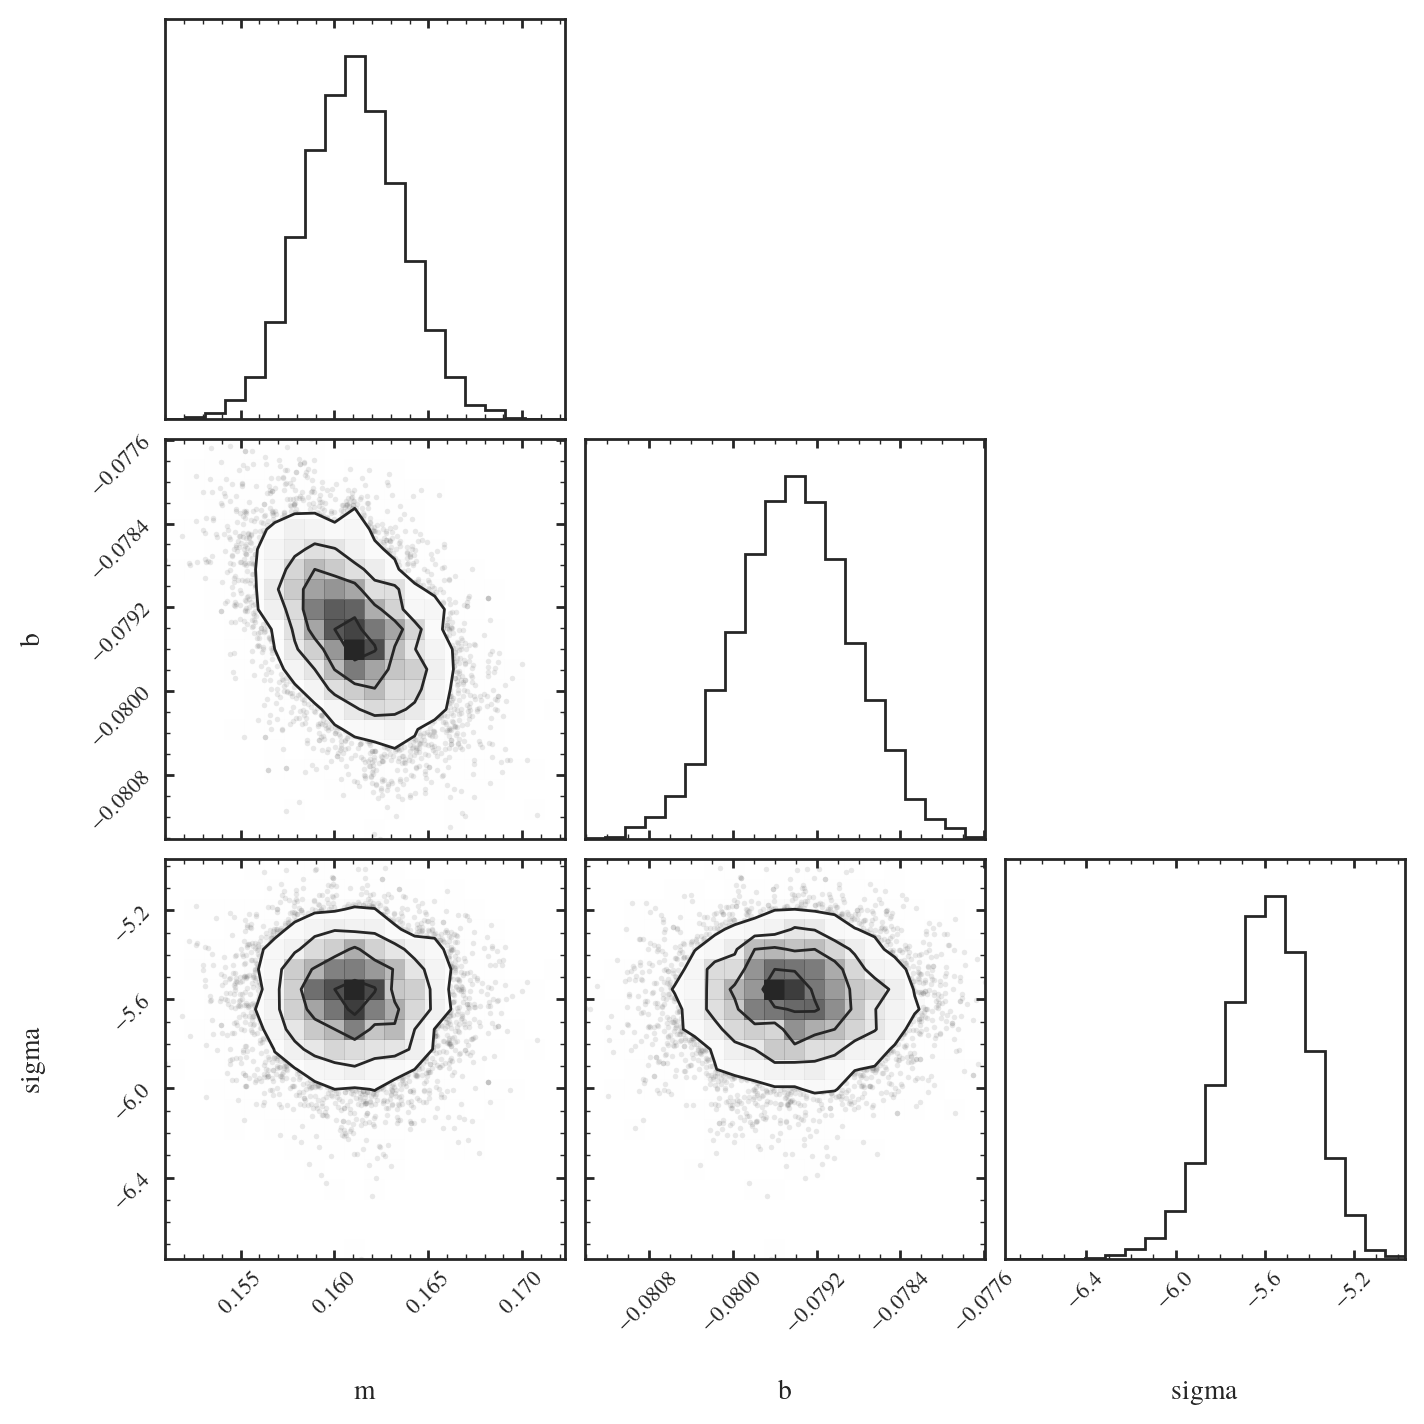

In [16]:
model = LinearModel()
p0 = model.p0(1)
ndim, nwalkers = len(p0), 50
p0 = p0 + 1e-6 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(model, obs))
sampler.run_mcmc(p0, 1000, progress=True);
samples = sampler.get_chain(discard=200, thin=5, flat=True)
corner(samples, labels=["m", "b", "sigma"]);

(-0.3, 0.1)

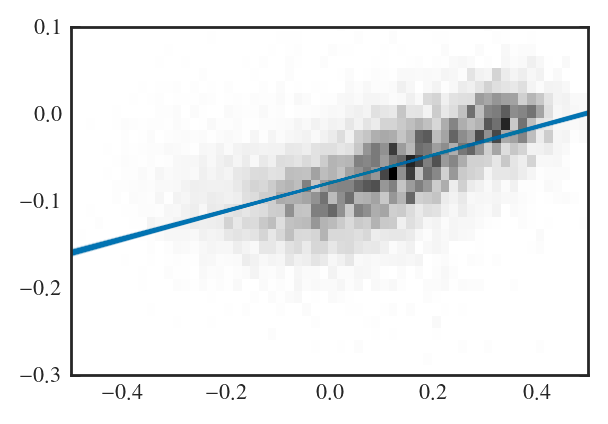

In [17]:
plt.hist2d(x_obs, y_obs, 200, cmap="Greys",alpha=1, weights=w);

for i in range(0, len(samples), 10):
    theta = samples[i, :]
    x = np.linspace(-0.5, 0.5, 1000)
    y = model(x, theta)
    plt.plot(x, y, lw=0.1, color=arya.COLORS[0], alpha=0.2, )
    
plt.xlim(-0.5, 0.5)
plt.ylim(-0.3, 0.1)


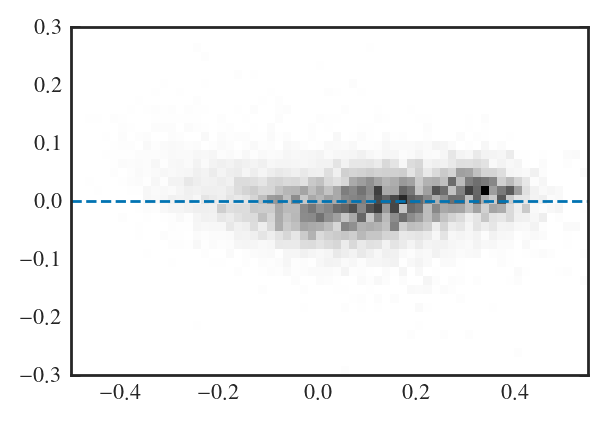

In [18]:
theta_m = np.median(samples, axis=0)
y_pred = model(x_obs, theta_m)

#plt.scatter(x_obs, y_obs - y_pred, s=2, c=w, ec="none", cmap="Greys", alpha=0.4)
plt.hist2d(x_obs, y_obs - y_pred, 200, weights=w, cmap="Greys", )
plt.ylim(-0.3, 0.3)
plt.xlim(-0.5)
plt.axhline(0, ls="--")

# Exponential model

In [19]:
surp.set_yields()

In [20]:
y_mg = vice.yields.ccsne.settings["mg"]

In [21]:
class ExpModel():
    def __init__(self):
        pass
            
    def __call__(self, x, theta):
        m, b, σ = theta
        Z = gcem.MH_to_Z(x)
        y_c =  b + m * (Z - Z_SUN)
        return gcem.abund_to_brak(y_c/y_mg, "c", "mg")
    
    def d_dx(self, x, theta):
        m, b, σ = theta
        return m + 0*x
    
    def log_prior(self, theta):
        m, b, log_sigma = theta
        p = 0
        p += norm.logpdf(m, loc=0, scale=0.05)
        p += norm.logpdf(b, loc=3e-3, scale=1e-3)
        p += norm.logpdf(log_sigma, loc=-4, scale=1)

        if np.isnan(p):
            return -np.inf
        return p
    
    def p0(self, N):
        return [0.01, 2e-3, 0.005]
    
    
    
    

In [22]:
model = ExpModel()
p0 = model.p0(1)
ndim, nwalkers = len(p0), 50
p0 = p0 *  (1 + 1e-1 * np.random.randn(nwalkers, ndim))


In [23]:
empty_obs = [np.array([]), np.array([]), np.array([]), np.array([])]

100%|██████████| 1000/1000 [00:23<00:00, 41.94it/s]


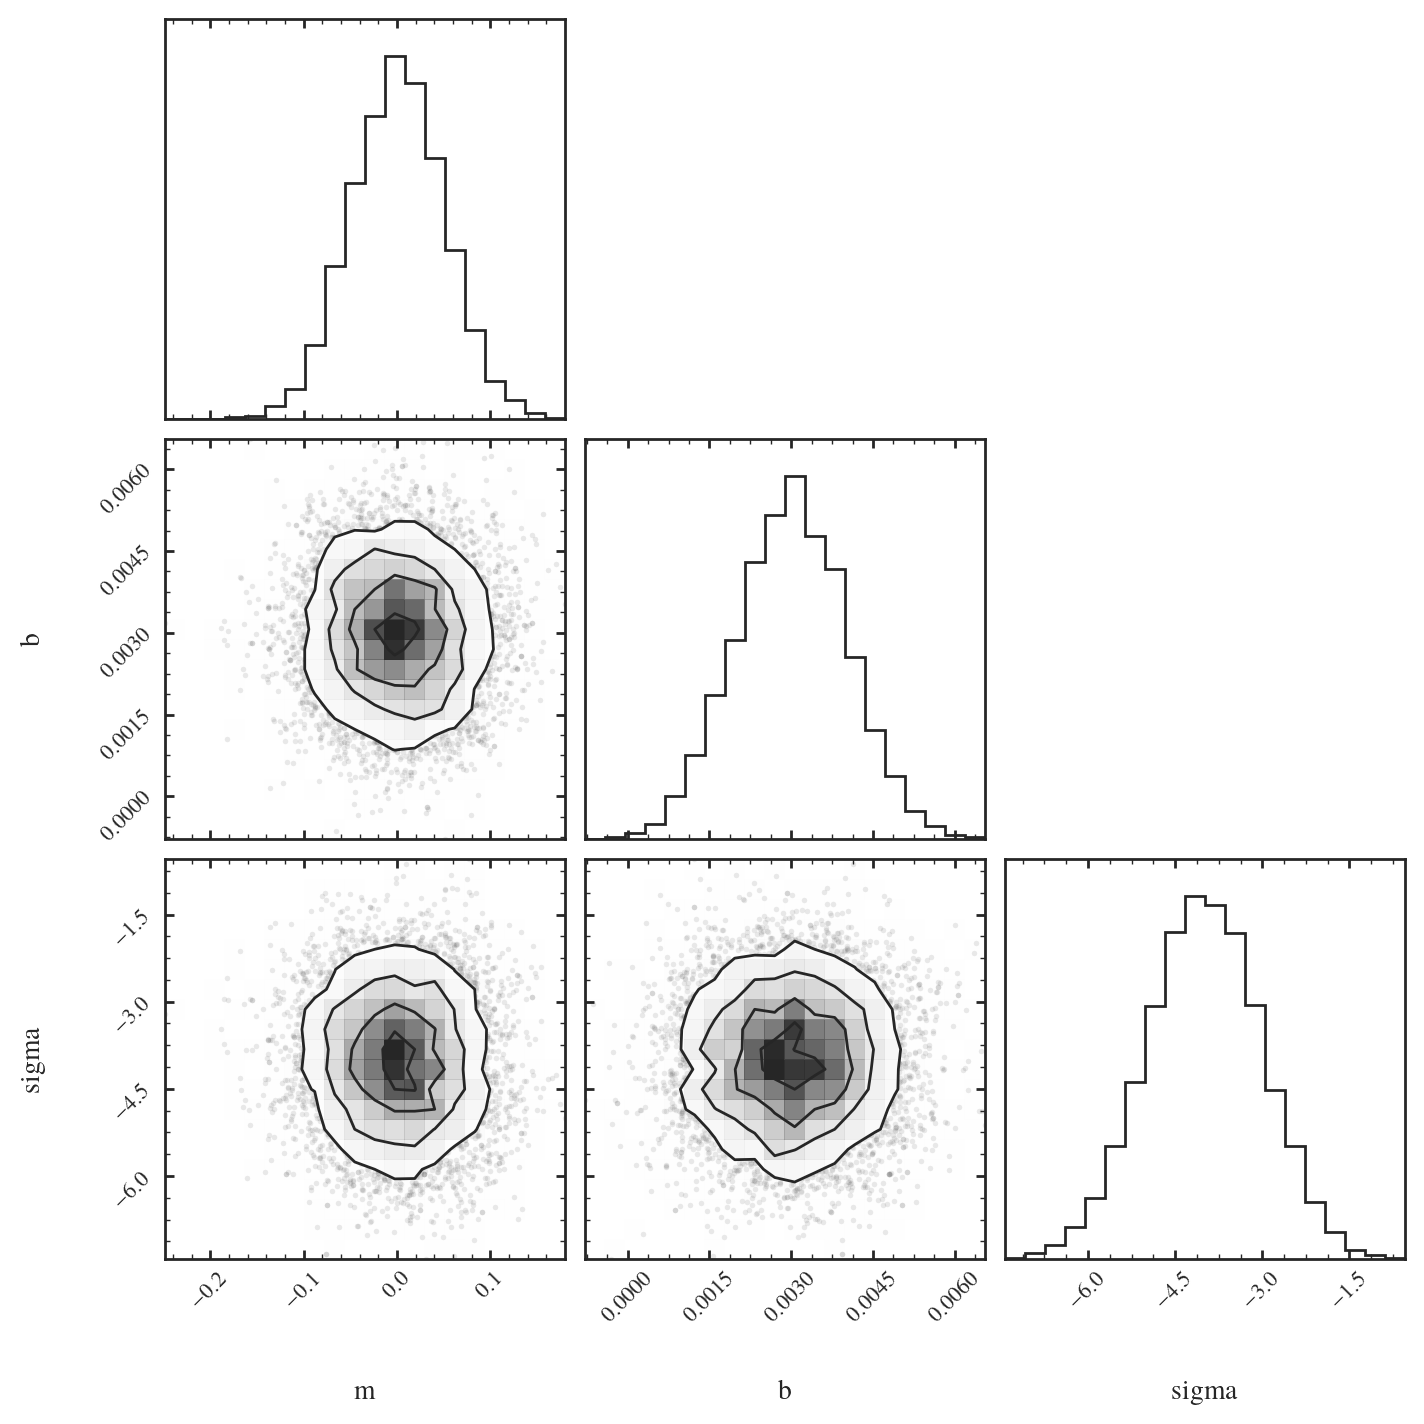

In [24]:
sp = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(model, empty_obs),)
sp.run_mcmc(p0, 1000, progress=True);
samples = sp.get_chain(discard=100, thin=5, flat=True)

corner(samples, labels=["m", "b", "sigma"]);

/users/PAS2232/aeyobd/surp/surp/gce_math.py:80: RuntimeWarning: invalid value encountered in log10
  return np.log10(data) - np.log10(vice.solar_z(ele) / vice.solar_z(ele2))


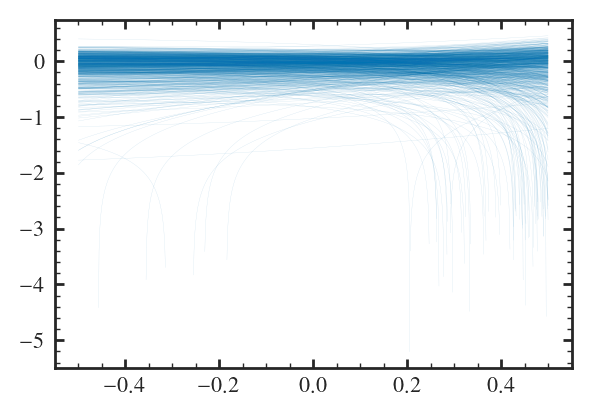

In [25]:

for i in range(0, len(samples), 10):
    theta = samples[i, :]
    x = np.linspace(-0.5, 0.5, 1000)
    y = model(x, theta)
    plt.plot(x, y, lw=0.1, color=arya.COLORS[0], alpha=0.2, )
  


100%|██████████| 1000/1000 [02:02<00:00,  8.16it/s]


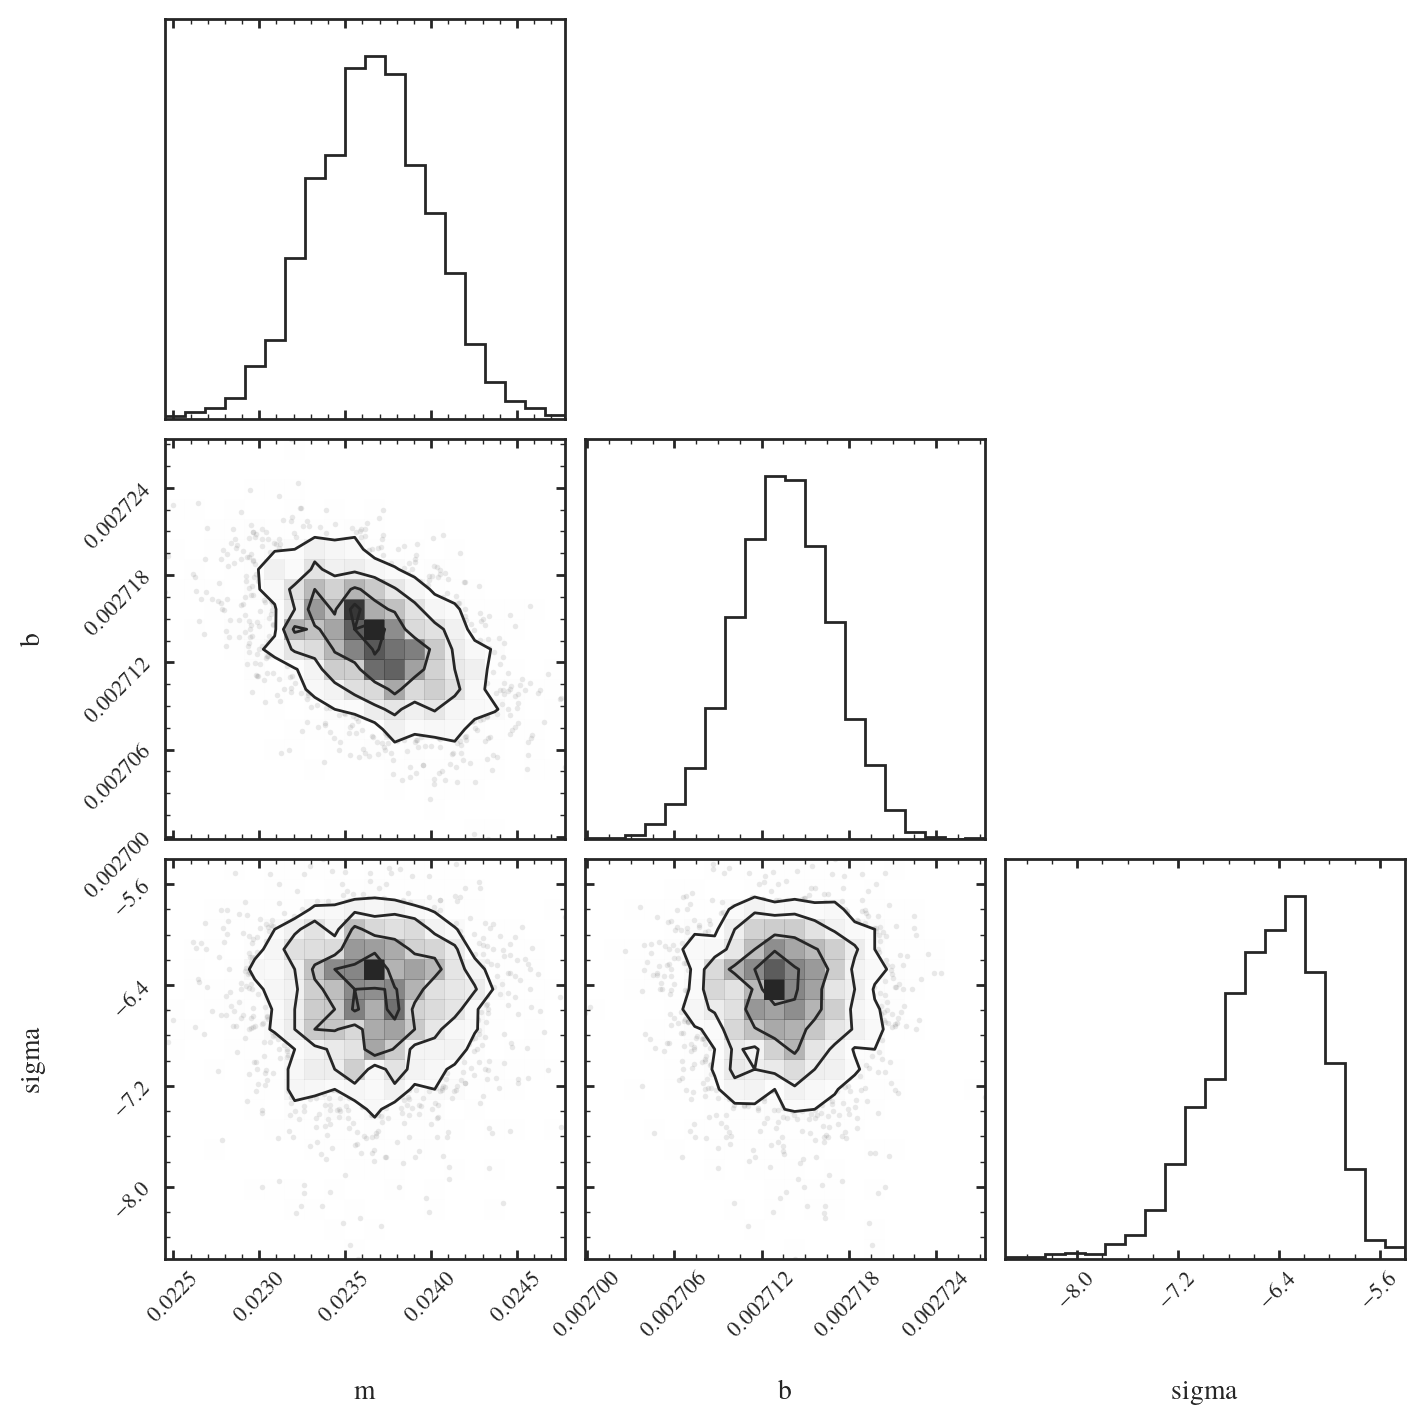

In [26]:

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(model, obs))
sampler.run_mcmc(p0, 1000, progress=True);
samples = sampler.get_chain(discard=200, thin=15, flat=True)
corner(samples, labels=["m", "b", "sigma"]);

(-0.3, 0.1)

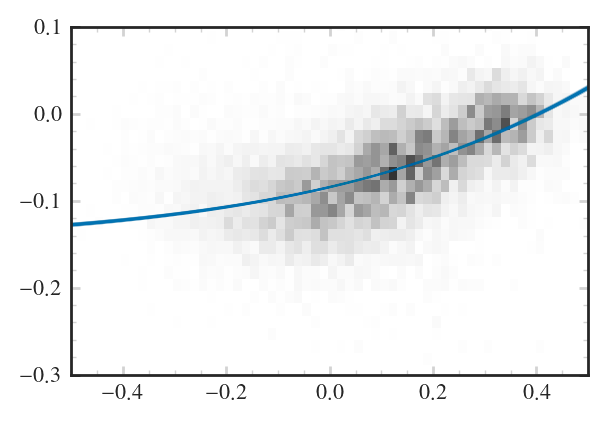

In [27]:
plt.hist2d(x_obs, y_obs, 200, weights=w, cmap="Greys", alpha=0.8);

for i in range(0, len(samples), 10):
    theta = samples[i, :]
    x = np.linspace(-0.5, 0.5, 1000)
    y = model(x, theta)
    plt.plot(x, y, lw=0.1, color=arya.COLORS[0], alpha=0.2, )
    
plt.xlim(-0.5, 0.5)
plt.ylim(-0.3, 0.1)

In [28]:
theta_m = np.median(samples, axis=0)

Text(0, 0.5, '[C/Mg]')

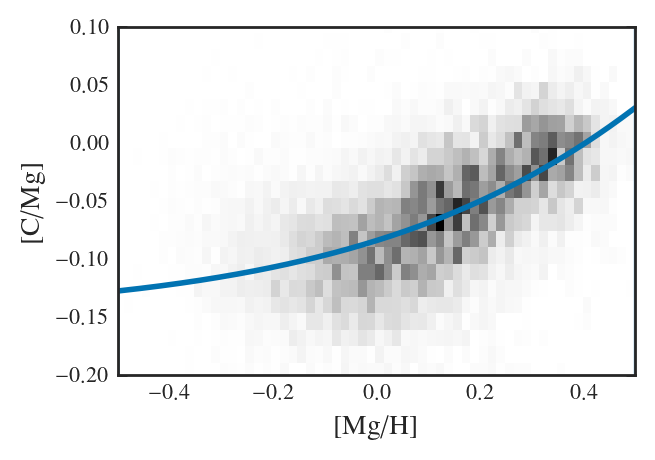

In [29]:
plt.hist2d(x_obs, y_obs, 200, weights=w, cmap="Greys", alpha=1);

x = np.linspace(-0.5, 0.5, 1000)
y = model(x, theta_m)
plt.plot(x, y, color=arya.COLORS[0],lw=2 )
sigma = theta_m[-1]
plt.fill_between(x, y - sigma, y+sigma, color=arya.COLORS[0], alpha=0.5, fc="none")
    
plt.xlim(-0.5, 0.5)
plt.ylim(-0.2, 0.1)
plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

Text(0, 0.5, '$y_{\\rm C} / y_{\\rm Mg}$')

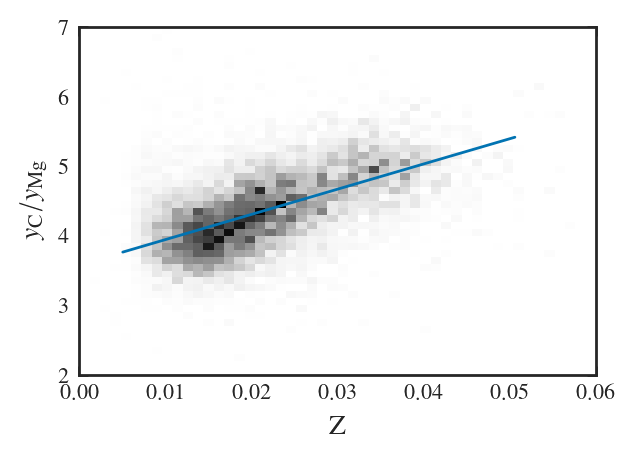

In [30]:
y1 = gcem.brak_to_abund(y_obs, "c", "mg")
x1 = gcem.MH_to_Z(x_obs)

plt.hist2d(x1, y1, weights=w, bins=50, cmap="Greys", range=((0, 0.06), (2, 7)));

y_m = gcem.brak_to_abund(y, "c", "mg")
x_m = gcem.MH_to_Z(x)
plt.plot(x_m, y_m)

y_l = gcem.brak_to_abund(y - sigma, "c", "mg")
y_h = gcem.brak_to_abund(y + sigma, "c", "mg")
#plt.fill_between(x_m, y_l, y_h, alpha=0.3)

plt.xlabel("Z")
plt.ylabel(r"$y_{\rm C} / y_{\rm Mg}$")

Text(0, 0.5, '[C/Mg]')

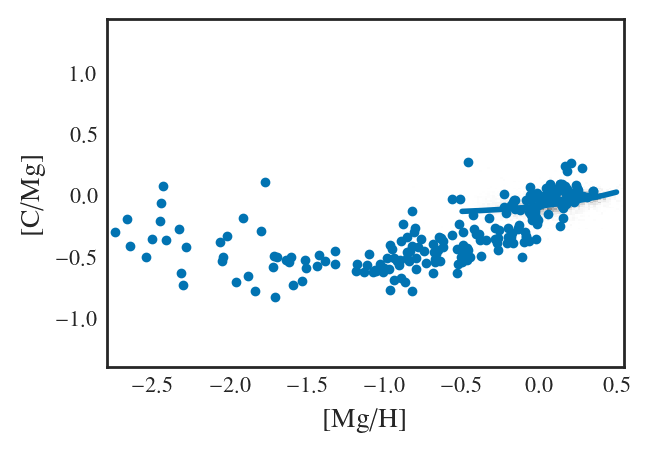

In [31]:
plt.hist2d(x_obs, y_obs, 200, weights=w, cmap="Greys", alpha=1);

x = np.linspace(-0.5, 0.5, 1000)
y = model(x, theta_m)
plt.plot(x, y, color=arya.COLORS[0],lw=2 )
sigma = theta_m[-1]

#plt.scatter(stars_x_obs, stars_y_obs)
plt.scatter(all_x_obs, all_y_obs)
plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

In [41]:
def print_stats(arr, pl=20, ph=None):
    if ph is None:
        ph = 100 - pl
    m = np.median(arr)
    l = np.percentile(arr, pl)
    h = np.percentile(arr, ph)
    print(f"median: {m:0.6f} - {m-l:0.6f} + {h-m:0.6f}")

In [42]:
print_stats(samples[:, 0])

median: 0.023660 - 0.000295 + 0.000289


In [38]:
samples[0, :]

array([ 2.30549987e-02,  2.71381448e-03, -6.17903023e+00])